# 상품 추천 결과 생성 및 DB 입력용 데이터 추출

# Step 1: 필요한 라이브러리 설치

In [1]:
!pip install transformers
!pip install sentence-transformers
!pip install torch
!pip install Pillow
!pip install tqdm


#  Step 2: CSV 파일 업로드


In [2]:
# from google.colab import files
# uploaded = files.upload()

KeyboardInterrupt: 

# Step 3: 데이터 불러오기 및 전처리

In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
df = pd.read_csv("store_product_DB.csv").fillna("")
df = df.fillna("")  # NaN 방지

# 가격 정규화
scaler = MinMaxScaler()
df["PRICE_SCALED"] = scaler.fit_transform(df[["PRICE"]])


# Step 4: 모델 불러오기

In [4]:
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
from io import BytesIO
import numpy as np
import requests
from tqdm import tqdm

kobert = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Step 5: 임베딩 생성 함수

In [26]:
SEASONS = ["봄", "여름", "가을", "겨울"]

# 개별 속성 임베딩 함수들
def encode_text(text):
    return kobert.encode([text], normalize_embeddings=True)[0]

def encode_image(image_url):
    try:
        response = requests.get(image_url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            img_vec = clip_model.get_image_features(**inputs)
            img_vec = img_vec / img_vec.norm(dim=-1, keepdim=True)
        return img_vec.squeeze().cpu().numpy()
    except:
        return np.zeros(512)

def encode_season(season_str):
    return np.array([1 if s in season_str else 0 for s in SEASONS], dtype=np.float32)

def encode_price(price_scaled):
    return np.array([price_scaled], dtype=np.float32)

# 벡터 생성
def build_embedding(row):
    brand_vec = encode_text(row["BRAND_NAME"])
    name_vec = encode_text(row["NAME"])
    desc_vec = encode_text(row["DESCRIPTION"])
    style_vec = encode_text(row["STYLE"])
    fit_vec = encode_text(row["FIT"])
    color_vec = encode_text(row["COLOR"])
    category_vec = encode_text(row["CATEGORY"])
    season_vec = encode_season(row["SEASON"])
    price_vec = encode_price(row["PRICE_SCALED"])
    image_vec = encode_image(row["IMAGE_URL"])

    combined = np.concatenate([
        brand_vec, name_vec, desc_vec, style_vec,
        fit_vec, color_vec, category_vec,
        season_vec, price_vec, image_vec
    ])
    norm = np.linalg.norm(combined)
    return combined / norm if norm != 0 else combined


# Step 6: 유사도 계산

In [27]:
embeddings = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    vec = build_embedding(row)
    embeddings.append((row["ID"], vec))

similarities = []
for i, (id1, vec1) in enumerate(embeddings):
    scores = []
    for j, (id2, vec2) in enumerate(embeddings):
        if id1 == id2:
            continue
        score = np.dot(vec1, vec2)
        scores.append((id2, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    top10 = scores[:10]
    for target_id, score in top10:
        similarities.append({
            "SOURCE_ID": id1,
            "TARGET_ID": target_id,
            "SCORE": round(score, 4)
        })


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


# Step 7: DB 입력용 SQL 출력

In [47]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# sqls = []
# for i, rec in enumerate(similarities):
#     sqls.append(
#         f"UPDATE RECOMMEND_RESULT "
#         f"SET SCORE = {rec['SCORE']}, "
#         f"UPDATED_AT = TO_TIMESTAMP('{now}', 'YYYY-MM-DD HH24:MI:SS'), "
#         f"UPDATED_BY = 0 "
#         f"WHERE SOURCE_ID = {rec['SOURCE_ID']} AND TARGET_ID = {rec['TARGET_ID']};"
#     )



for i, rec in enumerate(similarities):
    sqls.append(f"INSERT INTO RECOMMEND_RESULT (ID, SOURCE_ID, TARGET_ID, SCORE, CREATED_AT, CREATED_BY) "
                       f"VALUES (RECOMMEND_RESULT_SEQ.NEXTVAL, {rec['SOURCE_ID']}, {rec['TARGET_ID']}, "
                       f"{rec['SCORE']}, TO_TIMESTAMP('{now}', 'YYYY-MM-DD HH24:MI:SS'), 0);")

# 저장
with open("recommend_results.sql", "w", encoding="utf-8") as f:
    f.write("\n".join(sqls))

    from datetime import datetime



# Step 8: SQL 다운로드

In [48]:
from google.colab import files
files.download("recommend_results.sql")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ✅ PCA 시각화

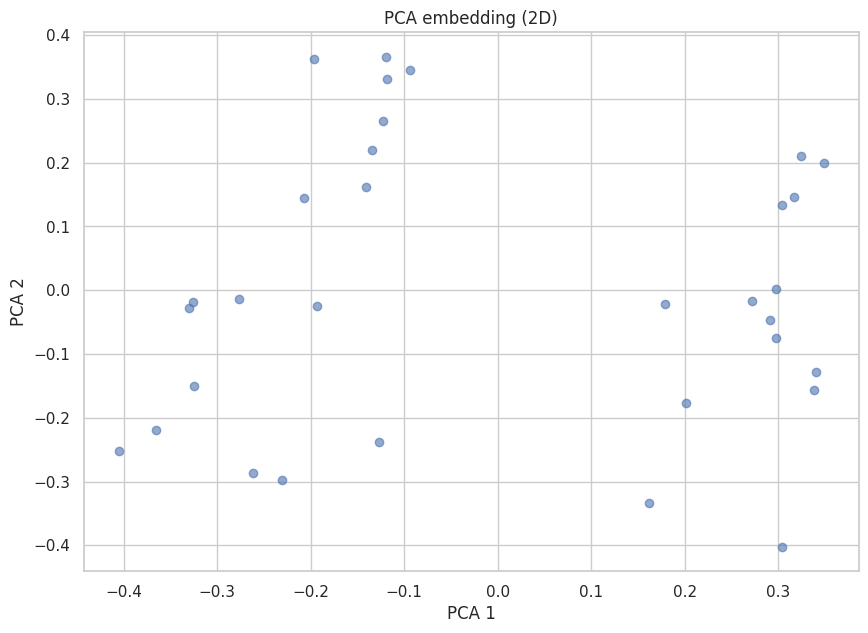

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. 임베딩 벡터만 추출
embedding_vectors = [vec for _, vec in embeddings]
product_ids = [pid for pid, _ in embeddings]

# 2. PCA로 2차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_vectors)

# 3. 시각화
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title("PCA embedding (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


# ✅ 2. 선택적으로 색깔로 그룹 나누기 (예: CATEGORY 기준)

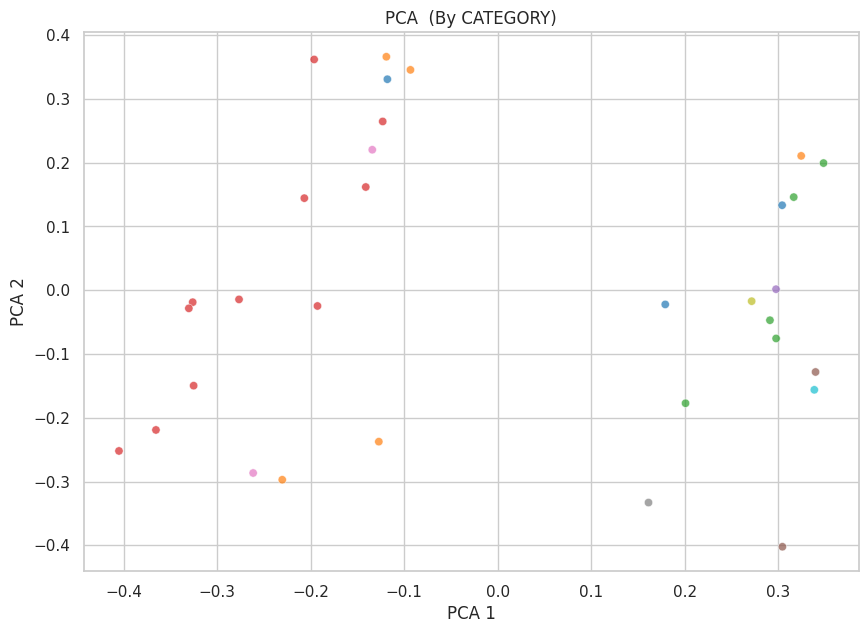

In [31]:
import seaborn as sns

categories = df["CATEGORY"].tolist()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=categories,
    palette="tab10",
    legend=False,  # 범례 숨기기 원하면 True로
    alpha=0.7
)
plt.title("PCA  (By CATEGORY)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


# ✅ 3. 주성분 중요도(설명력) 확인

In [32]:
explained = pca.explained_variance_ratio_
print(f"PC1 설명력: {explained[0]:.2%}")
print(f"PC2 설명력: {explained[1]:.2%}")
print(f"누적 설명력 (2D): {explained[:2].sum():.2%}")


PC1 설명력: 16.27%
PC2 설명력: 11.00%
누적 설명력 (2D): 27.27%


# 1. 설치 (UMAP

In [33]:
!pip install umap-learn

# ✅ 2. 임베딩 벡터 준비

In [34]:
embedding_vectors = [vec for _, vec in embeddings]
product_ids = [pid for pid, _ in embeddings]


# ✅ 3. t-SNE 시각화

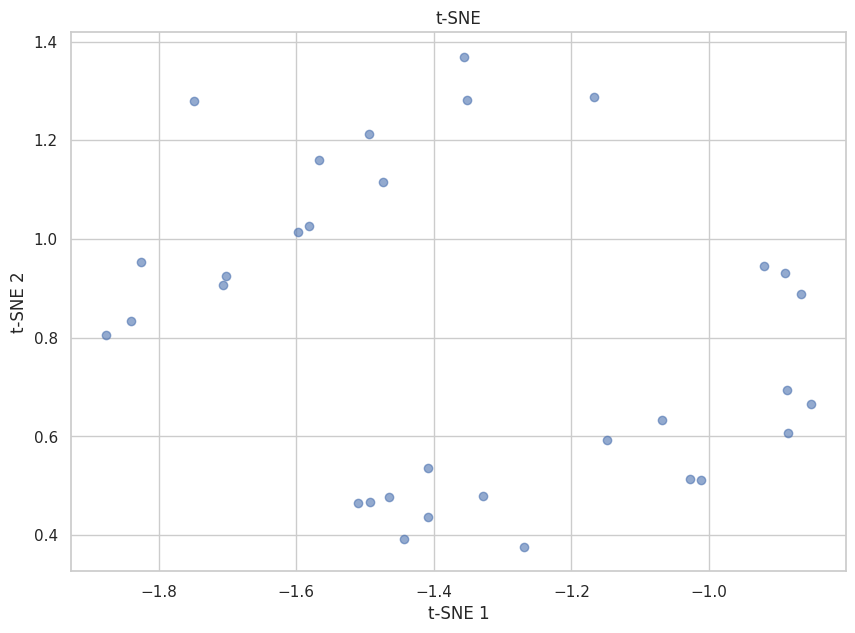

In [46]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 리스트를 NumPy 배열로 변환
embedding_array = np.array(embedding_vectors)

# t-SNE 수행
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='random')
tsne_result = tsne.fit_transform(embedding_array)

# 시각화
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
plt.title("t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


# ✅ 4. UMAP 시각화

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


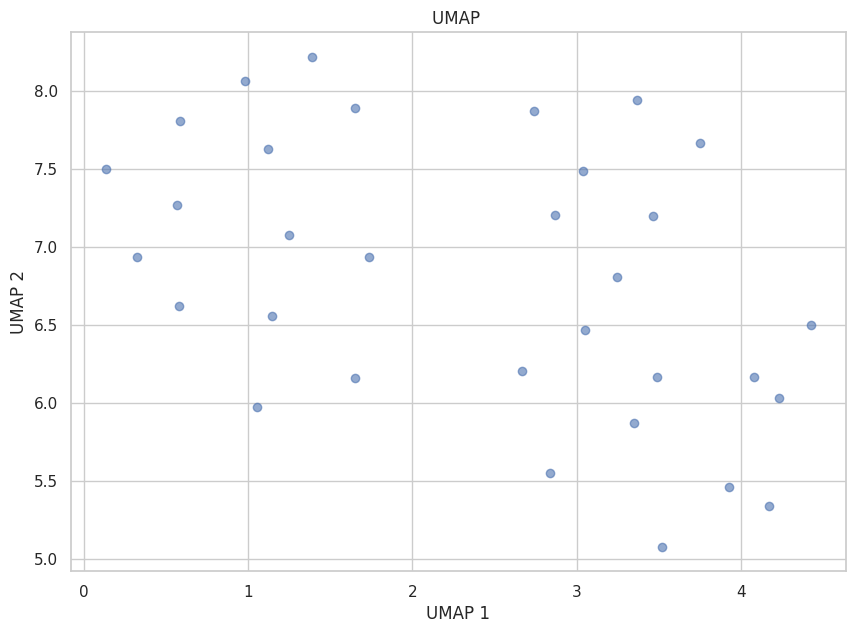

In [44]:
import umap.umap_ as umap

# UMAP 수행
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(embedding_vectors)

# 시각화
plt.figure(figsize=(10, 7))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.6)
plt.title("UMAP ")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


## ✅ 선택: 카테고리 기반 색상 그룹화 (예: CATEGORY 컬럼 사용)

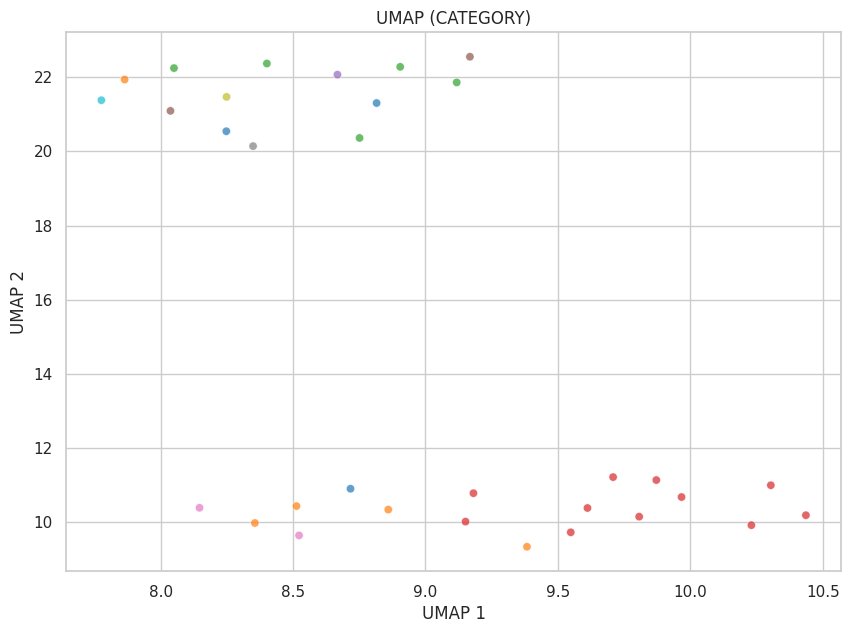

In [36]:
import seaborn as sns

categories = df["CATEGORY"].tolist()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=umap_result[:, 0],
    y=umap_result[:, 1],
    hue=categories,
    palette="tab10",
    alpha=0.7,
    legend=False
)
plt.title("UMAP (CATEGORY)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


# 통계 도출

In [37]:
import re
import pandas as pd

# 1. SQL 파일 불러오기
with open("recommend_results.sql", "r", encoding="utf-8") as f:
    lines = f.readlines()

# 2. 정규표현식으로 SCORE 값 추출
scores = []
for line in lines:
    match = re.search(r"VALUES\s*\(.*?,\s*.*?,\s*.*?,\s*(\d+\.\d+)", line)
    if match:
        scores.append(float(match.group(1)))

# 3. DataFrame으로 변환
df_scores = pd.DataFrame(scores, columns=["SCORE"])

# 4. CSV로 저장
df_scores.to_csv("recommend_results.csv", index=False)

# 5. Colab에서 다운로드
from google.colab import files
files.download("recommend_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

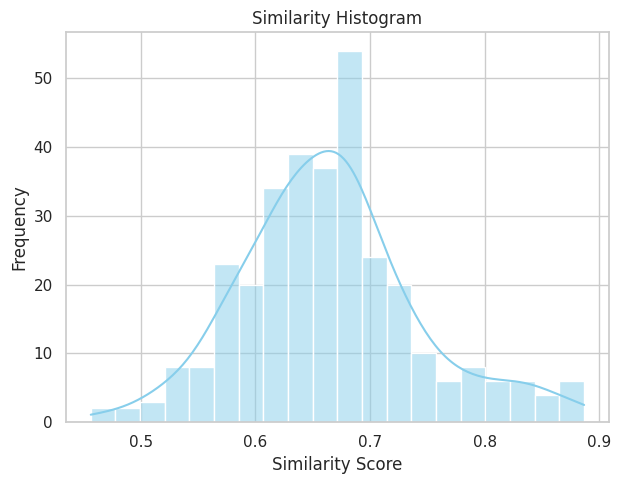

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 파일에서 데이터 불러오기 (또는 DB 연동 가능)
df = pd.read_csv('recommend_results.csv')  # SCORE 컬럼만 있는 CSV

# 스타일 설정
sns.set(style="whitegrid")

# 그래프 그리기
plt.figure(figsize=(12, 5))

# 1. 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df['SCORE'], bins=20, kde=True, color='skyblue')
plt.title('Similarity Histogram')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

## 2. 박스플롯
# plt.subplot(1, 2, 2)
# sns.boxplot(x=df['SCORE'], color='lightgreen')
# plt.title('Similarity Boxplot')
# plt.xlabel('Similarity Score')

plt.tight_layout()
plt.show()


In [39]:
# 유사도 통계 계산
mean_score = df_scores["SCORE"].mean()
max_score = df_scores["SCORE"].max()
min_score = df_scores["SCORE"].min()

print(f"유사도 평균: {mean_score:.4f}")
print(f"유사도 최고: {max_score:.4f}")
print(f"유사도 최저: {min_score:.4f}")


유사도 평균: 0.6649
유사도 최고: 0.8869
유사도 최저: 0.4562
